# The Finite Element Method
*Practical session during the [Daedalus Project P8: Regression for uncertainty quantification in PDE's with stochastic coefficients](https://daedalus-berlin.github.io/projects.html#p8), November, 2018.*

## Stationary Diffusion

Given a Lipschitz domain $D\subseteq\mathbb{R}^n$ the stationary diffusion equation with homogeneous Dirichlet boundary conditions, diffusion coefficient $\kappa$ and forcing term $f$ reads:
\begin{equation} \label{eq:pde}
\begin{aligned}
-\operatorname{div} (\kappa \nabla u) &= f &\text{in } D, \\
             u &= 0 &\text{on } \partial D
\end{aligned} \tag{1}
\end{equation}
This equation is the prime example for a linear elliptic *partial differential equation* (PDE).
In this notebook we will employ the *finite element method* to threat this problem numerically.
For this we will use `Python` and the `FEniCS` library.

## Solution

Not every PDE admits a solution in the classical sense.
A function $u$ is called

 - a classical solution of $(1)$ if it satisfies the equation exactly,
 - a strong solution of $(1)$ if
\begin{align}
\int_D - \operatorname{div}(\kappa \nabla u) v\ \mathrm{d}\lambda &= \int_D f v\ \mathrm{d}\lambda & \text{for all } v\in C^0(D)
\end{align}
 - and a weak solution of equation $(1)$ if
\begin{align}
\int_D \kappa \nabla u \cdot\nabla v\ \mathrm{d}\lambda &= \int_D f v\ \mathrm{d}\lambda & \text{for all } v\in C_0^1(D)
\end{align}
with $
C_0^k(D) := \left\{ w\in C^k(D) | w = 0 \text{ on } \partial D \right\}.
$

**Remark:**
Each solution concept has its own requirements on the regularity of $\kappa$, $f$ and $u$.
But note that a strong solution $u$ satisfies the equation almost everywhere and that the concept of a weak solution can be derived from that of a strong solution by the integration by parts formula.

Recall that the Sobolev space $H^1(D)$ is defined as the space of functions in $L^2(D)$ such that 
their distributional derivative has a representation in $L^2(D)$ as well.
$H^1(D)$ is a Hilbert space with inner product
$$
\langle f, g\rangle_{H^1(D)} = \int_D \left( fg  + \nabla f \cdot \nabla g \right) \mathrm{d}x.
$$
A weak solution can then be sought for in the closed subspace $H^1_0(D) \subseteq H^1(D)$ which is defined to be the closure of $C^\infty_0(D)$ with respect to the $H^1(D)$-norm.

To formalise this we define the bilinear form $a : H^1_0(D) \times H^1_0(D) \to \mathbb{R}$ and the linear form $L : H^1_0(D) \to \mathbb{R}$ as
$$
a(u,v) := \int_D \langle \kappa \nabla u, \nabla v\rangle\ \mathrm{d}\lambda
\qquad\text{and}\qquad L(v) := \int_D f v\ \mathrm{d}\lambda
$$
and rewrite the equation as
$$
a(u,v) = L(v) \qquad\text{for all } v \in V := H^1_0(D). \tag{2}
$$
Note that the function space $H^1_0(D)$ is chosen in such a way that $u = 0$ on $\partial D$ is ensured by definition in the sense of traces.

If $\kappa\in L^{\infty}(D)$ and $\kappa \ge \varepsilon > 0$ almost everywhere and $f\in H^{-1}(D)=H_0^1(D)^*$,  the **Lax-Milgram Theorem** ensures the existence and uniqueness of a solution $u$ such that
$$
\|u\|_{H^1_0(D)} \lesssim C(\varepsilon)\|f\|_{H^{-1}(D)}
$$

## Galerkin Projection

The *finite element method* (FEM) tries to approximate the solution of $(2)$ in a suitable finite dimensional function space $V_h \subseteq V$. Since the resulting equation is a linear equation on a finite dimensional vector space it induces a matrix equation for the coefficients of a chosen basis of $V_h$.

## Implementation

In [1]:
from fenics import *
% matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['figure.figsize'] = [3, 3]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.size'] = 12

#### FEM Spaces

The FE method uses piecewise pull-back functions of polynomials on a given partition of $D$ as the discrete solution spaces. In the case of a (vertex) triangular mesh, a pull-back function is a polynomial on each triangle.

In this example we will use *Lagrange Polynomials* of degree 1 on an automatically generated mesh.
`FEniCS`  allows us to specify the discrete function spaces, (bi)linear forms and boundary conditions in an intuitive way and takes care of the assembly the necessary matrix and vector.

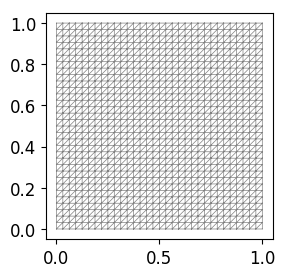

In [3]:
# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
fe_type = "Lagrange"
fe_degree = 1
V = FunctionSpace(mesh, fe_type, fe_degree)

plot(mesh)

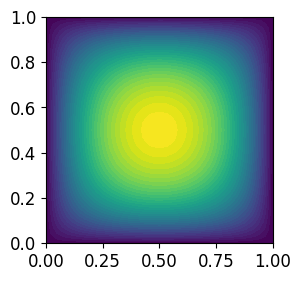

In [4]:
# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, 'on_boundary')

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
kappa = Constant(1)
f = Constant(1) # Expression("1", degree=3)
a = inner(kappa*grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

plot(u)

Now that we know how to solve the equation we can write a function that returns the solution given the diffusion coefficient $\kappa$ and forcing term $f$ as parameters.

In [5]:
def solution(kappa, f):
    u = TrialFunction(V)
    v = TestFunction(V)
    a = inner(kappa*grad(u), grad(v))*dx
    L = f*v*dx

    u = Function(V)
    solve(a == L, u, bc)
    return u

The diffusion coefficient $\kappa$ can be given as a FEnics function living on some discrete space or as an * parametric expression*. 

In [6]:
kappa = Expression("1 + exp(a * sin(2*pi*x[0]) * cos(2*pi*x[1]))", a=10, degree=3)

Moreover the *interpolate* routine of FEnics gives function representation on the given space based on interpolation.

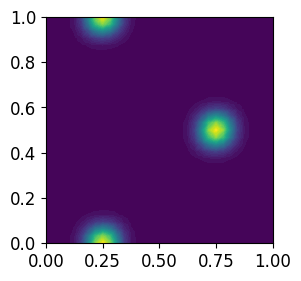

In [7]:
kappa_interp = interpolate(kappa,V)
plot(kappa_interp)

Now both versions of $\kappa$ (quadrature/interpolation based) can be used to solve the discrete problem. 

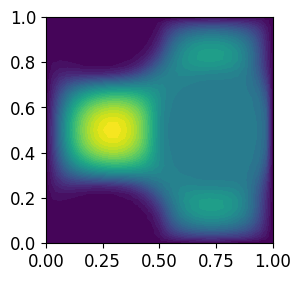

In [8]:
u = solution(kappa, f)
plot(u)

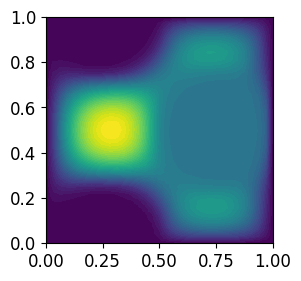

In [9]:
u = solution(kappa_interp, f)
plot(u)

End of part I. Next: *random fields*

<div style="text-align: right; color: #a5a9af"> &copy; Robert Gruhlke, Manuel Marschall, Phillip Trunschke, 2018-2019</div>